In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Cell 1 — Setup imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Notebook plotting style
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
# Cell 2 — Load the dataset
# Change filename to the actual path of your CSV (e.g., 'netflix_titles.csv')
fn = "netflix1.csv"
df = pd.read_csv(fn, dtype=str)   # load as string first to better handle messy cells
df_original = df.copy()
print("Loaded rows:", df.shape[0])
df.head()

Loaded rows: 8790


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [5]:
# Cell 3 — Quick overview & column cleaning
# Normalize column names (strip whitespace, lower-case)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df = df.rename(columns=lambda c: c.strip())

# Display info and missing counts
print("Columns:", list(df.columns))
print("\nMissing values by column:")
print(df.isnull().sum())
df.sample(5)

Columns: ['show_id', 'type', 'title', 'director', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in']

Missing values by column:
show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
4620,s6398,Movie,Cabin Fever,Travis Zariwny,United States,6/6/2019,2016,R,98 min,"Horror Movies, Thrillers"
173,s120,Movie,Here and There,JP Habac,Philippines,9/2/2021,2020,TV-MA,99 min,"Dramas, International Movies, Romantic Movies"
384,s285,Movie,The Kissing Booth 3,Vince Marcello,United Kingdom,8/11/2021,2021,TV-14,114 min,"Comedies, Romantic Movies"
4458,s6194,Movie,ATM,Mez Tharatorn,United States,9/5/2018,2012,TV-14,122 min,"Comedies, International Movies, Romantic Movies"
1105,s1125,Movie,Maximum Risk,Ringo Lam,United States,4/1/2021,1996,R,101 min,Action & Adventure


In [6]:
# Cell 4 — Drop duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped {before - after} duplicate rows. Remaining: {after}")

Dropped 0 duplicate rows. Remaining: 8790


In [7]:
# Cell 5 — Treat/replace obvious missing placeholders
# Some datasets use 'Not Given', 'N/A', 'na' etc. Convert common placeholders to np.nan
placeholders = ['not given', 'not available', 'n/a', 'na', 'none', 'unknown', '']
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].replace(placeholders, np.nan, regex=False)

print("Missing values after placeholder normalization:")
print(df.isnull().sum())

Missing values after placeholder normalization:
show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64


In [8]:
# Cell 6 — Convert data types and parse columns
# show_id -> string (already)
# type -> categorical
df['type'] = df['type'].astype('category')

# release_year -> int
if 'release_year' in df.columns:
    df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')

# date_added -> datetime (some rows might be NaN)
if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# rating -> leave as category
if 'rating' in df.columns:
    df['rating'] = df['rating'].astype('category')

df.dtypes

show_id                 object
type                  category
title                   object
director                object
country                 object
date_added      datetime64[ns]
release_year             Int64
rating                category
duration                object
listed_in               object
dtype: object

In [9]:
# Cell 7 — Extract duration numeric & duration type (min / season)
# Examples: '90 min' -> 90 & 'min'; '1 Season' -> 1 & 'Season'
def parse_duration(x):
    if pd.isna(x): return (np.nan, np.nan)
    x = str(x).strip()
    parts = x.split()
    # If first token is integer-like
    try:
        val = int(parts[0])
        # type is last token (min, Season(s))
        typ = parts[-1]
        return (val, typ)
    except:
        return (np.nan, np.nan)

if 'duration' in df.columns:
    parsed = df['duration'].apply(parse_duration)
    df['duration_value'] = parsed.apply(lambda t: t[0]).astype('Int64')
    df['duration_unit'] = parsed.apply(lambda t: t[1])

In [10]:
# Cell 8 — Split listed_in into genre list & explode if needed
# 'listed_in' holds comma-separated genres; create a list and a 'num_genres' column
if 'listed_in' in df.columns:
    df['listed_in'] = df['listed_in'].astype(str).replace('nan', np.nan)
    df['genres_list'] = df['listed_in'].dropna().apply(lambda x: [g.strip() for g in x.split(',')]) 
    # For rows with NaN, genres_list becomes NaN
    df['num_genres'] = df['genres_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [11]:
# Cell 9 — Fill or drop missing non-critical columns
# Decide strategy: for analysis we can keep rows with missing director/country but may fill a placeholder
df['director'] = df['director'].fillna("Unknown")
df['country'] = df['country'].fillna("Unknown")
# If you prefer to drop rows missing date_added or type, uncomment:
# df = df.dropna(subset=['date_added', 'type'])
print("After filling director/country:", df.isnull().sum())

After filling director/country: show_id           0
type              0
title             0
director          0
country           0
date_added        0
release_year      0
rating            0
duration          0
listed_in         0
duration_value    0
duration_unit     0
genres_list       0
num_genres        0
dtype: int64


Counts by type:
type
Movie      6126
TV Show    2664
Name: count, dtype: int64


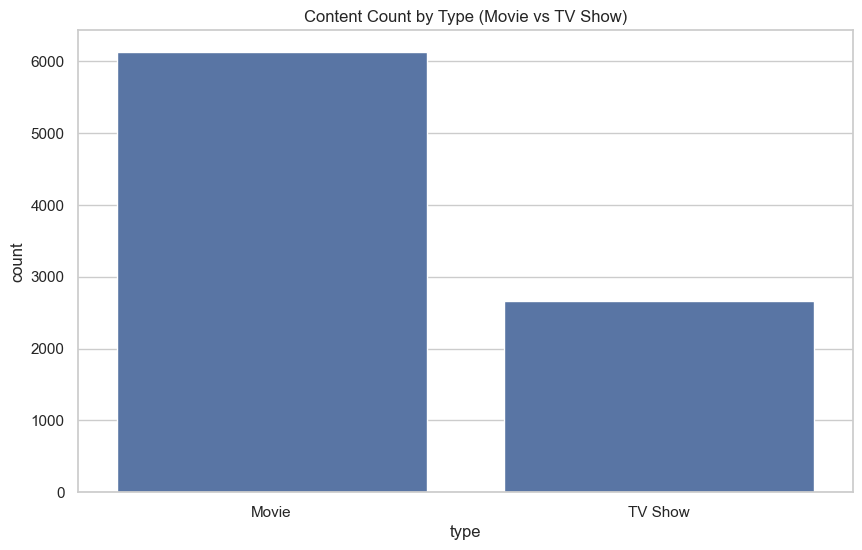

In [12]:
# Cell 10 — Basic EDA: counts by type
print("Counts by type:")
print(df['type'].value_counts(dropna=False))
sns.countplot(data=df, x='type')
plt.title("Content Count by Type (Movie vs TV Show)")
plt.show()

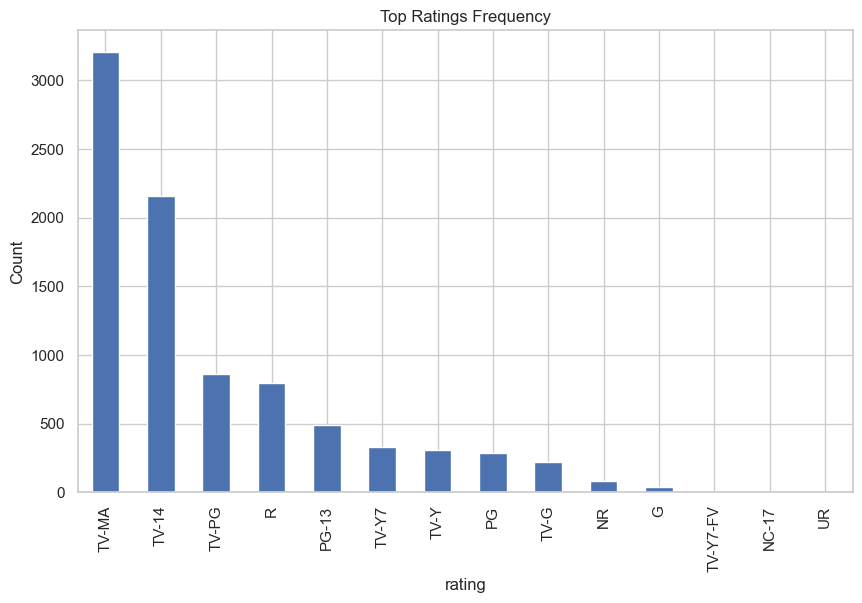

In [13]:
# Cell 11 — Ratings distribution
if 'rating' in df.columns:
    rating_counts = df['rating'].value_counts().head(20)
    rating_counts.plot(kind='bar')
    plt.title("Top Ratings Frequency")
    plt.ylabel("Count")
    plt.show()

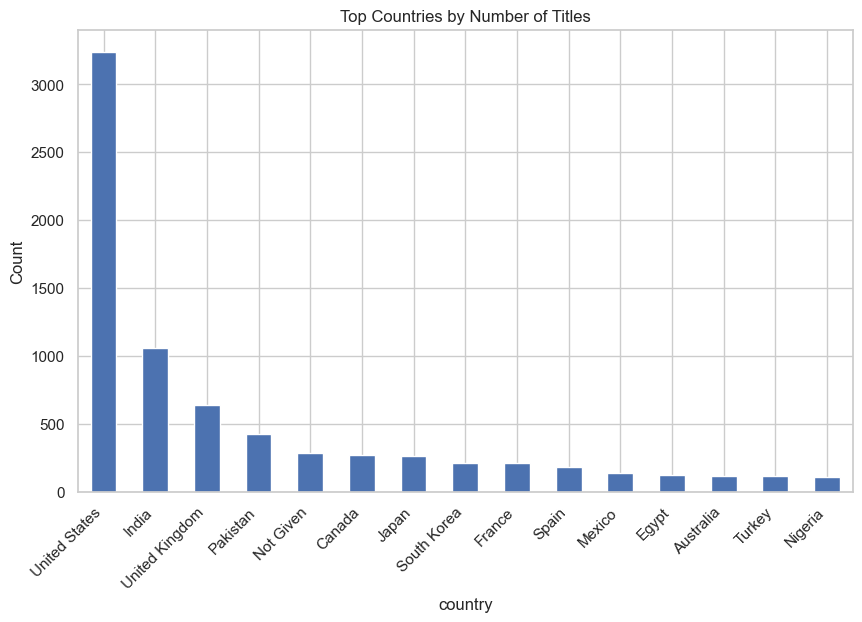

In [14]:
# Cell 12 — Top countries (content counts)
top_countries = df['country'].value_counts().nlargest(15)
top_countries.plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title("Top Countries by Number of Titles")
plt.ylabel("Count")
plt.show()

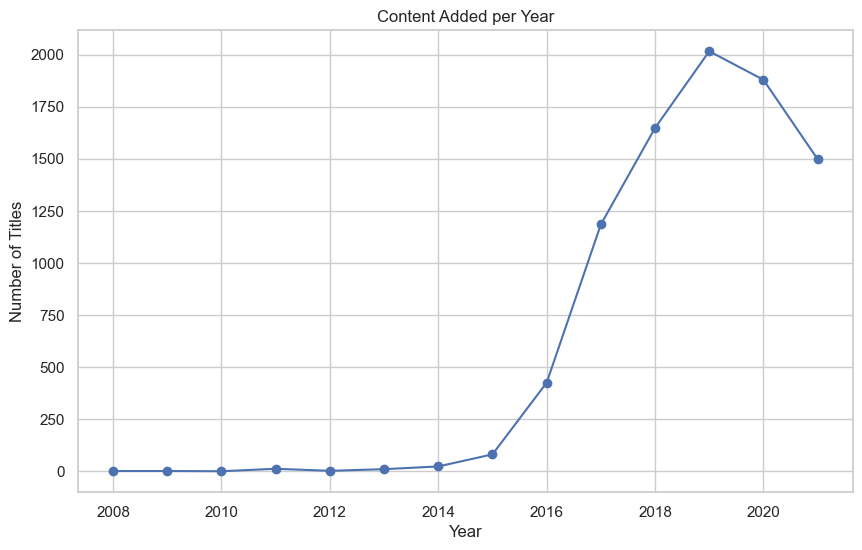

In [15]:
# Cell 13 — Year / Month analysis (use date_added if present)
if 'date_added' in df.columns:
    df['year_added'] = df['date_added'].dt.year.astype('Int64')
    df['month_added'] = df['date_added'].dt.month.astype('Int64')
    yearly = df['year_added'].value_counts().sort_index()
    yearly.plot(kind='line', marker='o')
    plt.title("Content Added per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Titles")
    plt.grid(True)
    plt.show()

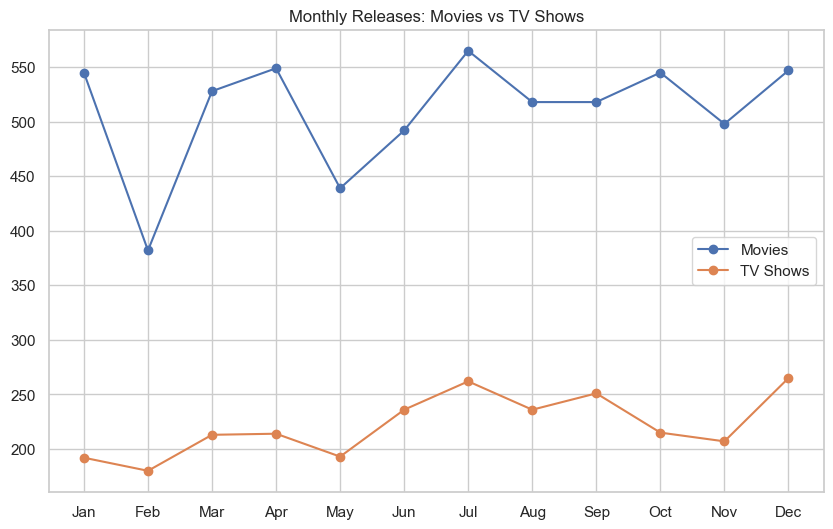

In [16]:
# Cell 14 — Monthly release pattern (movies vs tv shows)
if 'month_added' in df.columns and 'type' in df.columns:
    monthly_movies = df[df['type']=='Movie']['month_added'].value_counts().sort_index()
    monthly_shows  = df[df['type']=='TV Show']['month_added'].value_counts().sort_index()
    plt.plot(monthly_movies.index, monthly_movies.values, label='Movies', marker='o')
    plt.plot(monthly_shows.index, monthly_shows.values, label='TV Shows', marker='o')
    plt.xticks(range(1,13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.legend()
    plt.title("Monthly Releases: Movies vs TV Shows")
    plt.show()

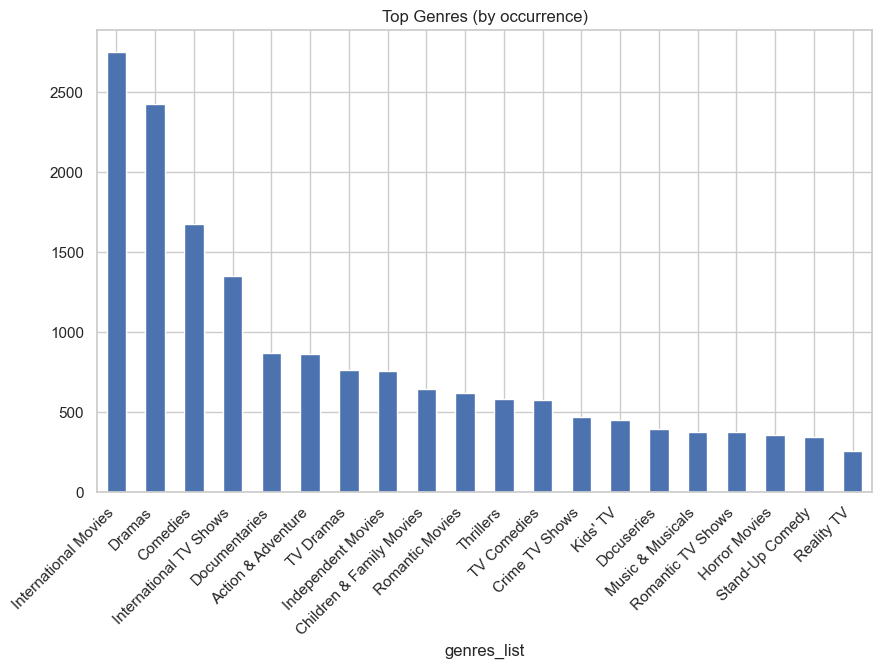

In [17]:
# Cell 15 — Top genres overall (flatten genres_list)
if 'genres_list' in df.columns:
    all_genres = df['genres_list'].dropna().explode()
    genre_counts = all_genres.value_counts().nlargest(20)
    genre_counts.plot(kind='bar')
    plt.xticks(rotation=45, ha='right')
    plt.title("Top Genres (by occurrence)")
    plt.show()

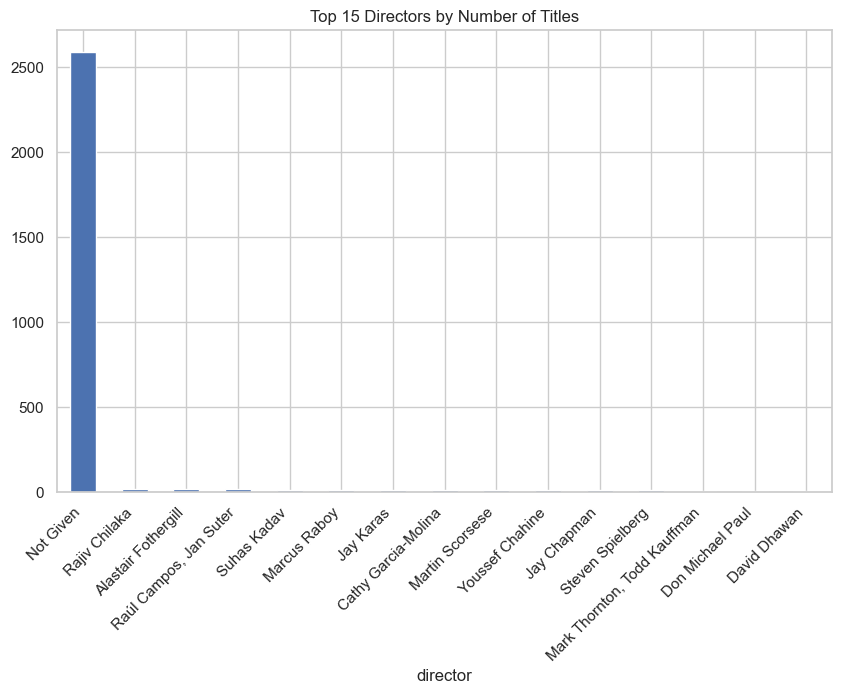

In [18]:
# Cell 16 — Top N directors
top_directors = df['director'].value_counts().nlargest(15)
top_directors.plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Directors by Number of Titles")
plt.show()

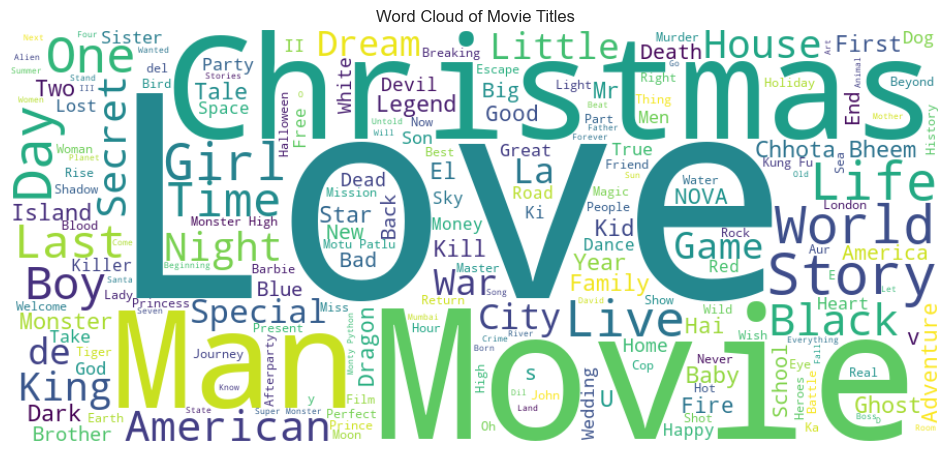

In [19]:
# Cell 17 — Word cloud of titles (movies only)
movie_titles = df[df['type']=='Movie']['title'].dropna().astype(str)
if len(movie_titles) > 0:
    wc = WordCloud(width=900, height=400, background_color='white').generate(" ".join(movie_titles))
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Movie Titles")
    plt.show()

In [20]:
# Cell 18 — Save cleaned dataset
clean_fn = "netflix_titles_cleaned.csv"
df.to_csv(clean_fn, index=False)
print("Cleaned dataset written to:", clean_fn)

Cleaned dataset written to: netflix_titles_cleaned.csv


In [21]:
# Cell 19 — Quick summary stats & export a small EDA CSV
summary = {
    'total_titles': [len(df)],
    'movies': [len(df[df['type']=='Movie'])],
    'tv_shows': [len(df[df['type']=='TV Show'])],
    'earliest_add_date': [df['date_added'].min() if 'date_added' in df.columns else None],
    'latest_add_date': [df['date_added'].max() if 'date_added' in df.columns else None]
}
summary_df = pd.DataFrame(summary)
summary_df.to_csv("netflix_summary.csv", index=False)
summary_df

,total_titles,movies,tv_shows,earliest_add_date,latest_add_date
0,8790,6126,2664,2008-01-01,2021-09-25
